In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import sem

from cpsplines.mosek_functions.interval_constraints import IntConstraints
from cpsplines.psplines.bspline_basis import BsplineBasis
from cpsplines.psplines.penalty_matrix import PenaltyMatrix
from cpsplines.fittings.fit_cpsplines import CPsplines
from cpsplines.utils.gcv import GCV
import statsmodels.genmod.families.family
import mosek.fusion as mf

from Functions import poly

from Functions import simpleGCV
from Functions import choose_lambda
from Functions import simpson_spline_full
from Functions import simpson_spline_matrices
from Functions import intGCV
from Functions import choose_lambda_int
from Functions import create_obj_mat
from Functions import unconstrained_sof_fit
from Functions import cp_sof_fit
import time
from scipy.stats import norm
from scipy import special

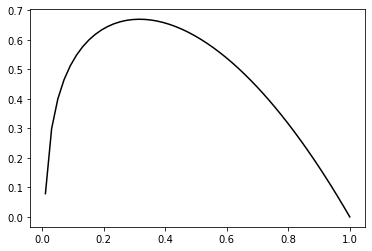

In [2]:
#ESTO PARA NUESTRO PROBLEMA
rankX = 20
alpha = 0.15
#Trabajaremos con estos datos
m = 50
T = np.linspace(0.01, 1, num=m)
Phi = np.append(np.tile(1/np.sqrt(m), (m, 1)), poly(T, degree=rankX-1)[0], axis = 1)
lambda1_ = np.arange(rankX, 0, -1)


T2 = np.linspace(0.01, 1, num=501)
# betaT = norm.pdf(T, loc=1.15, scale=0.4)
# betaT2  = norm.pdf(T2, loc=1.15, scale=0.4)
#betaT = 1/special.erf(T)*0.01
#betaT2 = 1/special.erf(T2)*0.01
# betaT = np.exp(-T**2)
# betaT2 = np.exp(-T2**2)

betaT = (np.log(T)+5)/5- T**2
betaT2 =( np.log(T2)+5)/5 - T2**2

X_log001_1_35

betaT=pd.read_csv("betaT_log.csv", header=None )
betaT=np.array(betaT).squeeze()
betaT2=pd.read_csv("betaT2_log.csv", header=None )
betaT2=np.array(betaT2).squeeze()


# betaT = 0.5*((2*T)**2+1/4-(2*T))
# betaT2 = 0.5*((2*T2)**2+1/4-2*T2)
# betaT = beta(T)
#weights. 1/3 for the limits, 2/3 for the odd subintervals, 4/3 for the even ones. 

w = [1/3] + [4/3 if i%2==0 else 2/3 for i in range(2,501)] + [1/3]
W = 1/501* np.diag(w)
plt.plot(T,betaT, 'k-')


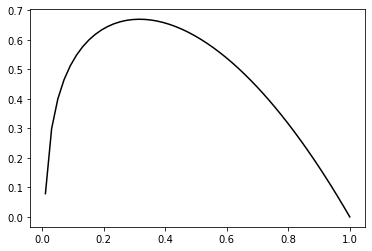

In [3]:
plt.plot(T,betaT, 'k-')

## ERROR SIGUE UNA $N(0, 0.01)$

### Gráficos

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


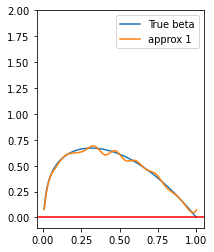

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


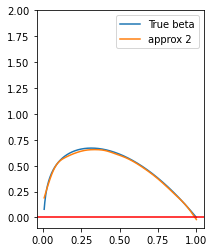

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


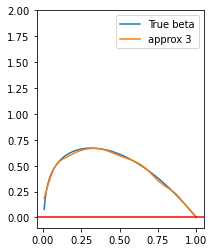

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


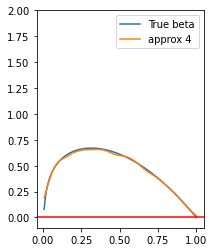

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


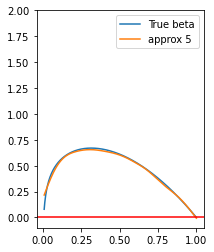

IMSE for N= 125 0.21163439951538782
MSE for N= 125 0.08580787120262136
Standard deviation of the IMSE: 3.7042708356836175e-05
Standard deviation of the MSE: 6.633661838661174e-06


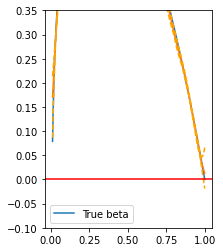

In [46]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 5

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

for N in [125]:
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_log001', str(i+1), str(N)])
        tttt="_".join(['y_log001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None)
        y = pd.read_csv("".join([tttt,'.csv']), header=None)
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        plt.figure(figsize=(3,4))
        plt.plot(T2, betaT2, label = 'True beta')
        plt.plot(T2,betagorro, label=f'approx {i+1}')
        plt.axhline(0, color='red')
        plt.ylim([-0.1, 1])
        plt.legend()
        plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE))
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.1, 1])
plt.legend()
plt.show()

### Cálculo del IMSE y del MSE

In [47]:
import warnings
warnings.filterwarnings('ignore')

IMSE for N= 35 0.4859574973294649
MSE for N= 35 0.06715585194605726
Standard deviation of the IMSE: 4.47038421972327e-05
Standard deviation of the MSE: 2.007769963079596e-06
IMSE for N= 75 0.2977909548214939
MSE for N= 75 0.08798441809771979
Standard deviation of the IMSE: 2.3713705163904345e-05
Standard deviation of the MSE: 1.2534548570602948e-06
IMSE for N= 125 0.20638328745108822
MSE for N= 125 0.08960943128597697
Standard deviation of the IMSE: 5.624383364399939e-06
Standard deviation of the MSE: 1.0103902980789876e-06


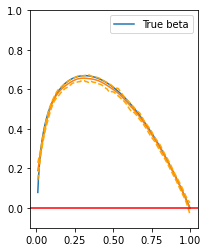

Times [153.69141078 235.54624104 345.44048429]


In [48]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_uncons001=np.zeros(n_sims)
MSE_uncons001=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_log001', str(i+1), str(N)])
        tttt="_".join(['y_log001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None)
        y = pd.read_csv("".join([tttt,'.csv']), header=None)
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_uncons001[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_uncons001[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE_uncons001.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE_uncons001.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_uncons001))
    print('Standard deviation of the MSE:', sem(MSE_uncons001))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.1, 1])
plt.legend()
plt.show()
print('Times', time_unconstrained)

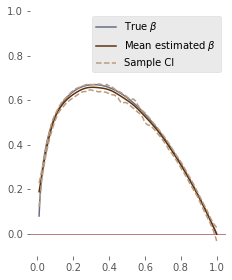

In [8]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.1, 1])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('parabola_conv_001uncons.png', transparent=True)
plt.show()

## CONSTRAINED: ERROR SIGUE UNA $N(0, 0.01)$

### Plots

In [ ]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 5

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

cont=0
for N in [125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_log001', str(i+1), str(N)])
        tttt="_".join(['y_log001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None)
        y = pd.read_csv("".join([tttt,'.csv']), header=None)
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=2, sign='-', sign_threshold=0.00,  plot=False)
        plt.figure(figsize=(3,4))
        plt.plot(T2, betaT2, label = 'True beta')
        plt.plot(T2,betagorro, label=f'approx {i+1}')
        plt.axhline(0, color='red', linewidth=0.5)
        plt.ylim([-0.1, 1])
        plt.legend()
        plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.1, 1])
plt.legend()
plt.show()
print('Times', time_unconstrained)

### Cálculo del IMSE y del MSE

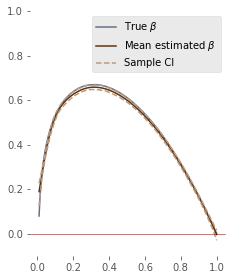

In [10]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.1, 1])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('parabola_conv_001cons.png', transparent=True)
plt.show()